In [3]:
import wandb
run = wandb.init()
artifact = run.use_artifact('lcruz1-university-of-alberta/BBI_reproduction/q_values_seed_16:v0', type='model')
artifact_dir = artifact.download()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: lcruz1 (lcruz1-university-of-alberta). Use `wandb login --relogin` to force relogin


wandb:   1 of 1 files downloaded.  


wandb: WARNING Fatal error while uploading data. Some run data will not be synced, but it will still be written to disk. Use `wandb sync` at the end of the run to try uploading.


In [4]:
import numpy as np

q_values = np.load('artifacts/q_values_seed_16:v0/q_values_seed_16.npz')['q_values']

In [5]:
# positions x intensities x prize_indicator x actions

q_values.shape

(11, 3, 4, 2)

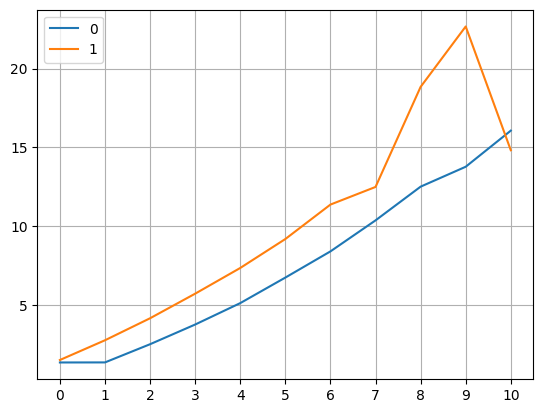

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(q_values[:, :1, :1, :].reshape(11,2)).plot(grid=True, xticks=range(11))
plt.show()

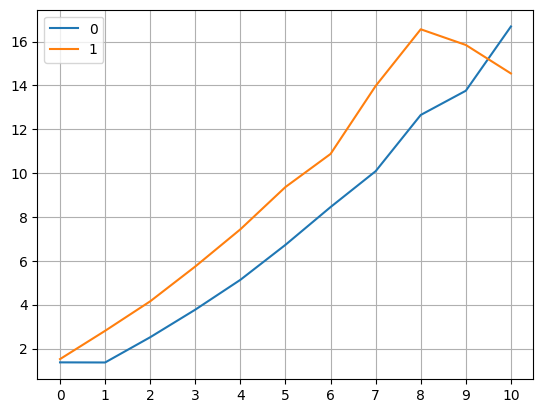

In [8]:
# positions x intensities x prize_indicator x actions

pd.DataFrame(q_values[:, 1:2, :1, :].reshape(11,2)).plot(grid=True, xticks=range(11))
plt.show()

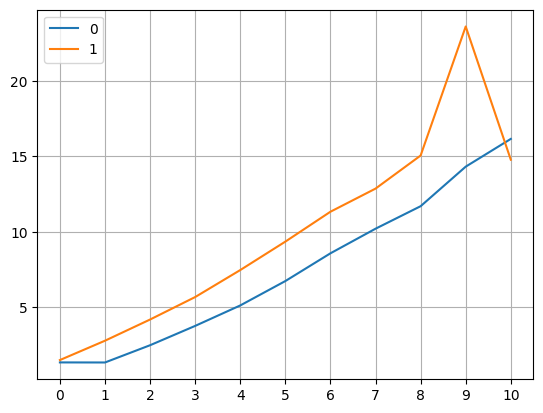

In [9]:
# positions x intensities x prize_indicator x actions

pd.DataFrame(q_values[:, 2:3, :1, :].reshape(11,2)).plot(grid=True, xticks=range(11))
plt.show()

In [10]:
# positions x intensities x prize_indicator x actions

q_values

array([[[[ 1.36468258,  1.52159011],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],

        [[ 1.36859683,  1.51770032],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],

        [[ 1.36284509,  1.51908757],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ]]],


       [[[ 1.36910373,  2.77309574],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],

        [[ 1.36364015,  2.80776767],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],

        [[ 1.35882119,  2.800222  ],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ]]],


       [[[ 2.52251063,  4.16799498],
         [ 0.        ,  0.        ],
         [ 0.        ,

In [1]:
from src.environments.goright import GoRightEnv

In [2]:
env = GoRightEnv(seed=1, is_observation_noisy=True)

In [13]:
env.observation_space.sample()['intensity']

0

In [36]:
import numpy as np
seed = 42


42

In [4]:
env.reset()

asd


(array([-0.09408427, -0.19168388,  0.1638513 , -0.04540043]), {})

In [5]:
env.step(1)
env.step(1)
env.step(1)
env.step(1)
env.step(1)
env.step(1)
env.step(1)
env.step(1)
env.step(1)

(array([ 8.90591573, -0.19168388,  0.1638513 , -0.04540043]),
 -1,
 False,
 False,
 {})

In [6]:
env.step(0)

(array([ 7.90591573,  4.80831612,  0.1638513 , -0.04540043]),
 0,
 False,
 False,
 {})

In [10]:
env.step(1)

(array([9.90591573, 4.80831612, 1.1638513 , 0.95459957]), 3, False, False, {})

In [28]:
from src.environments.goright import GoRightEnv
from src.agents.q_learning import QLearning

base_env = GoRightEnv(seed=42)
agent = QLearning(learning_rate=0.05, env_action_space=base_env.action_space)

In [29]:
obs, info = base_env.reset()

In [42]:
print(obs)
action = agent.get_action(obs, greedy=False)
print(action)
next_obs, reward, terminated, truncated, info = base_env.step(action)
print(next_obs, reward)
obs=next_obs

[ 3 10  0  0]
0
[2 5 0 0] 0


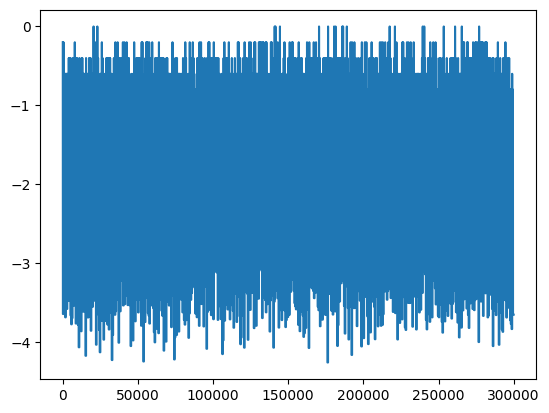

In [20]:
return_dict = np.load
returns_over_time = np.zeros((training_loops, n_steps))

for seed in np.arange(5):
    returns_over_time += return_dict[seed]["returns_over_time"]

returns_over_time /= 5

pd.Series(returns_over_time.flatten()).plot()
plt.show()

In [24]:
obs = [0, 0, 1, 1]

sum(int(round(obs[2 + i])) * (2 ** i) for i in range(2))

3

Found 20 runs in group 'GoRight_QLearning_RandomInit'. Downloading metrics...


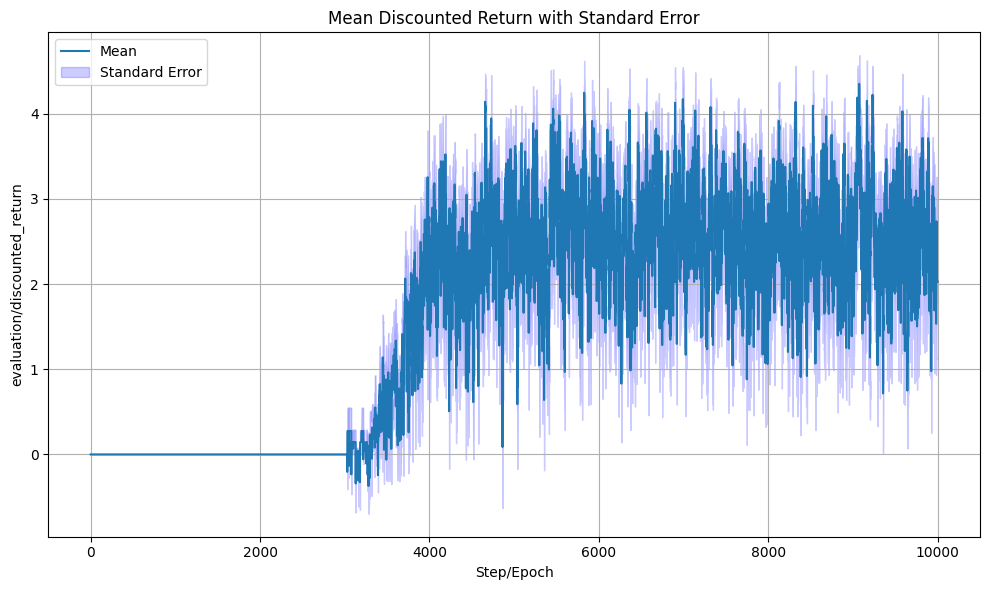

In [48]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from tqdm import tqdm

def download_group_runs(entity, project, group_name, metric_name='evaluation/discounted_return'):
    """
    Downloads all runs from a specified group in a Wandb project.

    Args:
        entity (str): The entity (user or team) name.
        project (str): The project name.
        group_name (str): The group name to filter runs.
        metric_name (str): The metric to extract from runs.

    Returns:
        List of pandas DataFrames containing the metric for each run.
    """
    api = wandb.Api()
    # Query runs in the specified group
    runs = api.runs(f"{entity}/{project}", {"group": group_name})
    
    if not runs:
        print(f"No runs found in group '{group_name}' for project '{entity}/{project}'.")
        return []
    
    print(f"Found {len(runs)} runs in group '{group_name}'. Downloading metrics...")
    
    run_metrics = []
    
    for run in tqdm(runs, desc="Downloading runs"):
        history = run.history(keys=[metric_name], pandas=True, x_axis='evaluation/step', samples=300_000)
        if metric_name in history.columns:
            # Reset index to get step or epoch information if needed
            history = history.reset_index()
            run_metrics.append(history[[metric_name]].dropna())
        else:
            print(f"Metric '{metric_name}' not found in run '{run.name}'. Skipping.")
    
    return run_metrics

def aggregate_metrics(run_metrics, metric_name='evaluation/discounted_return'):
    """
    Aggregates metrics from multiple runs by computing mean and standard error.

    Args:
        run_metrics (List[pandas.DataFrame]): List of DataFrames containing the metric.
        metric_name (str): The metric name.

    Returns:
        Tuple of (mean_series, stderr_series)
    """
    # First, align all runs by their step or epoch
    # Assuming that the metric is logged per step or epoch and indexed similarly
    # We'll concatenate along columns and compute statistics row-wise
    metric_dfs = [df.reset_index(drop=True) for df in run_metrics]
    concatenated = pd.concat(metric_dfs, axis=1)
    
    mean = concatenated.mean(axis=1)
    stderr = concatenated.sem(axis=1)  # Standard Error of the Mean
    
    return mean, stderr

def plot_metrics(mean, stderr, metric_name='evaluation/discounted_return', title='Mean Discounted Return with Standard Error'):
    """
    Plots the mean metric with standard error as a shaded region.

    Args:
        mean (pandas.Series): Mean values.
        stderr (pandas.Series): Standard error values.
        metric_name (str): The metric name.
        title (str): The plot title.
    """
    plt.figure(figsize=(10, 6))
    x = np.arange(len(mean))
    
    plt.plot(x, mean, label='Mean')
    plt.fill_between(x, mean - stderr, mean + stderr, color='b', alpha=0.2, label='Standard Error')
    
    plt.xlabel('Step/Epoch')
    plt.ylabel(metric_name)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main():
    # Configuration - replace these with your actual entity, project, and group names
    entity = "lcruz1-university-of-alberta"         # e.g., "username" or "teamname"
    project = "BBI_reproduction"       # e.g., "my-awesome-project"
    group_name = "GoRight_QLearning_RandomInit" # e.g., "experiment_group_1"
    metric_name = "evaluation/discounted_return"
    
    # Download runs
    run_metrics = download_group_runs(entity, project, group_name, metric_name)
    
    if not run_metrics:
        print("No metrics to plot.")
        return
    
    # Aggregate metrics
    mean, stderr = aggregate_metrics(run_metrics, metric_name)
    
    # Plot
    plot_metrics(mean, stderr, metric_name)

main()


In [43]:
api = wandb.Api()
entity = "lcruz1-university-of-alberta"         # e.g., "username" or "teamname"
project = "BBI_reproduction"       # e.g., "my-awesome-project"
group_name = "GoRight_QLearning_RandomInit" # e.g., "experiment_group_1"
metric_name = "evaluation/discounted_return"
# Query runs in the specified group
runs = api.runs(f"{entity}/{project}", {"group": group_name})

run_metrics = []

for run in tqdm(runs, desc="Downloading runs"):
    history = run.history(keys=[metric_name], pandas=True, x_axis='evaluation/step', samples=300_000)
    run_metrics.append(history[[metric_name]].dropna())

In [47]:
history

,evaluation/step,evaluation/discounted_return
0,3,0.00000
1,44,0.00000
2,56,0.00000
3,71,0.00000
4,163,0.00000
...,...,...
9995,299848,5.49682
9996,299870,5.49682
9997,299918,5.49682
9998,299958,5.49682
